In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
%reload_ext autoreload

In [205]:
# Standart Libraries

import numpy as np

# Import files

import utilities
from Filter import ExtendedKalmanFilter
from Radar import Radar
from RadarSystem import RadarSystem
from Earth import Earth
from Satellite import Satellite
from SatelliteState import SatelliteState

from config import config


In [206]:
# Initialize Earth
earth = Earth()


# Initialize RadarSystem
# Beijing Aerospace Command and Control Center

BACC =  RadarSystem(Earth(), 300)


# Initialize Satellite
R = config['satellite']['initial_conditions']['distance']
theta = config['satellite']['initial_conditions']['polar_angle']
phi = config['satellite']['initial_conditions']['azimuthal_angle']

#phi = config['satellite']['initial_conditions']['polar_angle']
#theta = config['satellite']['initial_conditions']['azimuthal_angle']


#angular_vel = 0.0010830807404
angular_vel = 0.0011313
tang_vel = angular_vel * R
radial_velocity = 0
azimuthal_velocity = 0


sat_state = SatelliteState(np.array([R, theta, phi]), np.array([0]), np.array([radial_velocity, tang_vel, azimuthal_velocity]), np.array([0]))
tiagong = Satellite(sat_state, 0, earth=earth)

In [207]:
list_position = np.array([radar.position for radar in BACC.radars])

In [208]:
# Initialize the Kalman Filter
# tianhe is the chinese super computer

#mean_0 = np.array([earth.re+380000, 0, 0.1, np.pi/2, angular_vel, 0])
r_noise = config['radar']['noise']['rho']
t_noise = config['radar']['noise']['theta']
mean_0 = np.array([R+100000, 0, 0, np.pi-3, 0, 0])

# cov_0 = np.array([
#     [3.98e8, 0, 0, 0, 0, 0],
#     [0, 1.092e1, 0, 0, 0, 0],
#     [0, 0, 1e0, 0, 0, 0],
#     [0, 0, 0, 1.9533, 0, 0],
#     [0, 0, 0, 0, 5.194e-1, 0],
#     [0, 0, 0, 0, 0, 8.03e-2]
# ])

cov_0 = np.array([
    [1e4, 0, 0, 0, 0, 0],
    [0, 1e1, 0, 0, 0, 0],
    [0, 0, 1e0, 0, 0, 0],
    [0, 0, 0, 1e1, 0, 0],
    [0, 0, 0, 0, 1e0, 0],
    [0, 0, 0, 0, 0, 1e-2]
])

observation_noise = np.array([[2e2, 0],
              [0, 1e-1]])

Q = np.array([
    [100, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 0.1, 0, 0, 0],
    [0, 0, 0, 0.2, 0, 0],
    [0, 0, 0, 0, 0.02, 0],
    [0, 0, 0, 0, 0, 0.002]
])

tianhe = ExtendedKalmanFilter(mean_0, cov_0, earth, observation_noise=observation_noise, process_noise=Q)


In [209]:
n = 10000000
simulation = tiagong.simulate(10000000)

sim_lenght = len(simulation.y[0])


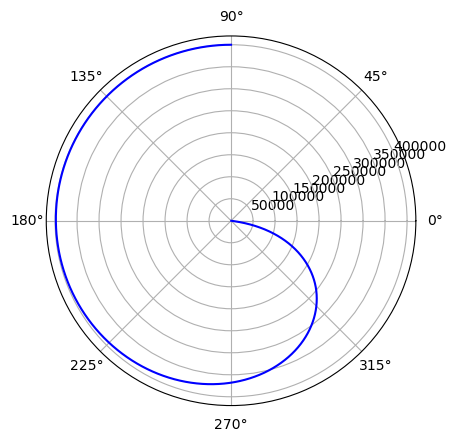

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

#n=np.argmin(np.abs(sol.y[0]-earth_radius))

R = simulation.y[0][:]-6378136.6
rad = simulation.y[2][:]
Phi = [np.pi/2 for i in rad]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [211]:
from copy import deepcopy

In [212]:
m = deepcopy(mean_0)

In [213]:
m = np.array([m[0], m[3]])

In [214]:
predicted_states_satellite_cord = [m]
radar_states_satellite_cord = [m]

In [215]:
for i in range(int(sim_lenght)):
    
    if i < sim_lenght:
        current_state_satellite_cord = tiagong.get_position_at_t(i)
        current_state_earth_cord = utilities.spherical_to_spherical(current_state_satellite_cord)
        #current_state_earth_cord = current_state_satellite_cord
        noise_states_earth_cord = BACC.try_detect_satellite(current_state_earth_cord, i)

        if len(noise_states_earth_cord) > 0:
            #print("Enter")
            flag = 0
            for state_earth_cord in noise_states_earth_cord:
                #state_satellite_cord = np.array([0,0,0])
                state_satellite_cord = utilities.earth_to_orbit(state_earth_cord.pos)
                #state_satellite_cord = state_earth_cord.pos
                new_state_satellite_cord = tianhe.update(state_satellite_cord)

                if flag == 0:
                    #print(state_satellite_cord)
                    radar_states_satellite_cord += state_satellite_cord,
                    flag = 1
            
    forecast = tianhe.forecast()
    new_state_satellite_cord = [forecast[0][0][0], forecast[0][3][0]]

    predicted_states_satellite_cord += new_state_satellite_cord,

    #if earth.distance_to_surface(utilities.spherical_to_spherical(np.array([forecast[0][0][0], forecast[0][3][0], config['satellite']['initial_conditions']['azimuthal_angle']])))['inside']:
        #break




In [216]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
R2 = R2 - 6378136.6
Phi = [np.pi/2 for i in rad]

In [217]:
len(R2)

4056

In [218]:
radar_states_satellite_cord

R3, rad3 = np.array(radar_states_satellite_cord[1:]).T
R3 = R3 - 6378136.6

In [219]:
len(radar_states_satellite_cord)

676

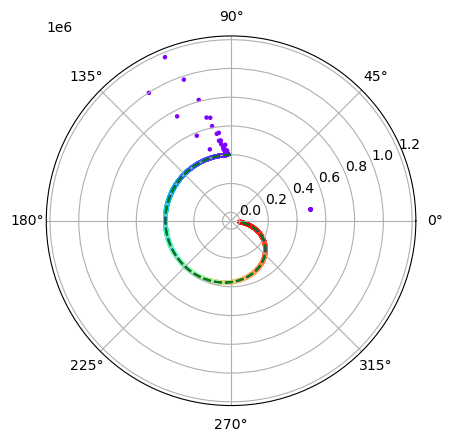

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.rainbow(np.linspace(0, 1, len(R2)))

ax.plot(rad, R, c='b', linestyle="dashed")
ax.scatter(rad2, R2, c=colors, s=5)
ax.plot(rad3, R3, c='g', linestyle="dashed")

plt.show()

In [221]:
predicted_states_satellite_cord

[array([6.87813600e+06, 1.41592654e-01]),
 [6878136.0, 0.14159265358979312],
 [6878136.0, 0.14159265358979312],
 [6878133.893611098, 0.14159265358979312],
 [6878129.680833294, 0.14159265358979312],
 [6878123.361666588, 0.14159265358979312],
 [6878114.93610969, 0.14159265358979312],
 [6777919.259665354, 1.6714303496920733],
 [6777539.92176331, 1.7655037749664388],
 [6837145.0460481, 1.8595772001769242],
 [6956731.294383617, 1.9536506253229295],
 [7136295.309377475, 2.0477240504042227],
 [7376364.622591544, 2.141797475476986],
 [6849130.967438574, 1.647782800105379],
 [6936740.175854651, 1.7091981235515108],
 [7049913.4995610025, 1.770613446970326],
 [7188918.538531577, 1.8320287703866533],
 [7354085.794149991, 1.893444093802852],
 [7545842.204260933, 1.9548594172190479],
 [6808527.614557685, 1.6273121042045882],
 [6841221.517360221, 1.6626186732230828],
 [6882362.596685049, 1.6979252422325402],
 [6931988.722408905, 1.7332318112387575],
 [6990140.669734069, 1.7685383802439019],
 [7056869

In [222]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
trd = [np.pi/2 - theta]*len(R2)

In [223]:
utilities.spherical_to_spherical(np.array([R2,rad2,trd]).T[500])

array([ 6.77819725e+06,  9.04810167e-01, -7.49552037e-01])

In [224]:
utilities.spherical_to_spherical(np.array([R2,rad2,trd]).T[501])

array([ 6.77824621e+06,  9.05316278e-01, -7.50670211e-01])

In [225]:
predicted_states_earth_cord = np.array([utilities.spherical_to_spherical(np.array([R2,rad2,trd]).T[i]) for i in range(len(predicted_states_satellite_cord))])

In [226]:
predicted_states_earth_cord

array([[6.87813600e+06, 1.46735602e+00, 1.47393514e+00],
       [6.87813600e+06, 1.46735602e+00, 1.47393514e+00],
       [6.87813600e+06, 1.46735602e+00, 1.47393514e+00],
       ...,
       [6.37934620e+06, 1.66607971e+00, 1.65994965e+00],
       [6.37854956e+06, 1.66604625e+00, 1.65991808e+00],
       [6.37775051e+06, 1.66601796e+00, 1.65989138e+00]])

In [227]:
x, y, z = utilities.earth_to_xyz_bulk(predicted_states_earth_cord).T

In [228]:
x

array([ 661627.6235772 ,  661627.6235772 ,  661627.6235772 , ...,
       -565410.41743621, -565141.9172016 , -564903.8020885 ])

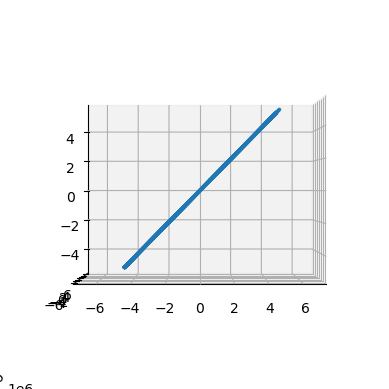

In [229]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(x, y, z, s = 3)


ax.view_init(0, -90)
ax.set_xlim([-7e6, 7e6])
ax.set_ylim([-7e6, 7e6])

plt.show()

In [230]:
from main import Main
import matplotlib.pyplot as plt
import numpy as np
from config import config
import utilities

In [231]:
main = Main(200)

In [232]:
main.simulate()

In [233]:
main.predict()

In [234]:
R, rad, R2, rad2, R3, rad3 = main.output() # True, predicted, radar

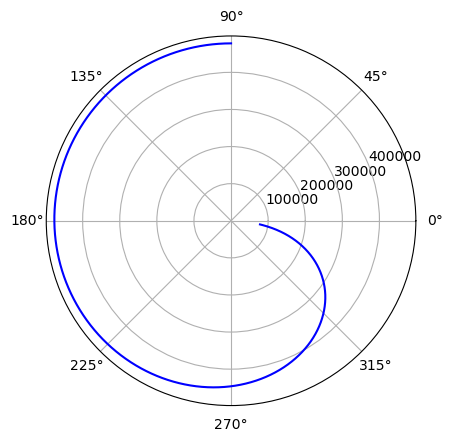

In [235]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R-6300000, c='b')

plt.show()

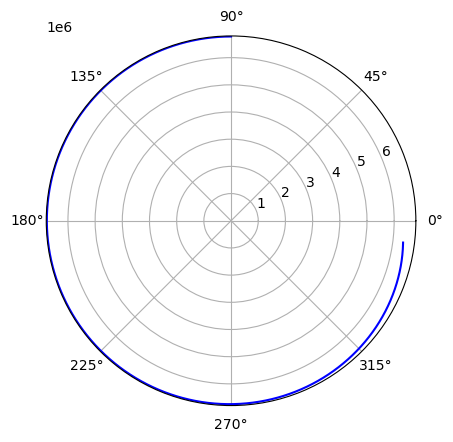

In [236]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [237]:
trd = [np.pi/2 - config['satellite']['initial_conditions']['polar_angle']]*len(R)

In [238]:
predicted_states_earth_cord = np.array([utilities.spherical_to_spherical(np.array([R,rad,trd]).T[i]) for i in range(len(R))])

In [239]:
x, y, z = utilities.earth_to_xyz_bulk(predicted_states_earth_cord).T

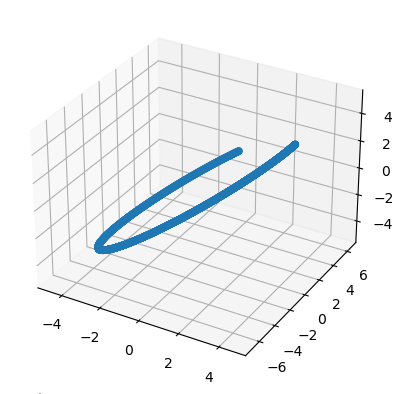

In [240]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(x, y, z)

plt.show()